In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

# Dataset

## Data visualization

In [2]:
# Reading the image datasets:
img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
# img_path = '/kaggle/input/iris/Iris.csv'
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')
lung_imgs = os.listdir(img_path+'/Lung_Opacity')

Normal chest x-ray


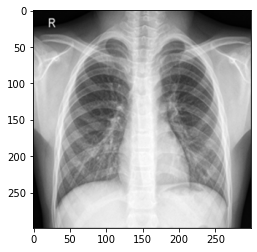

In [3]:
print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

Covid chest x-ray


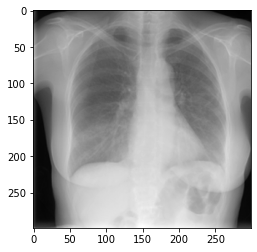

In [4]:
print("Covid chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

Viral Pneumonia chest x-ray


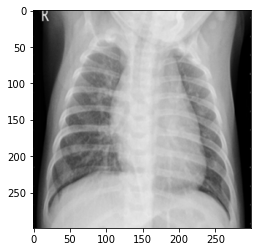

In [5]:
print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

Lung_Opacity chest x-ray


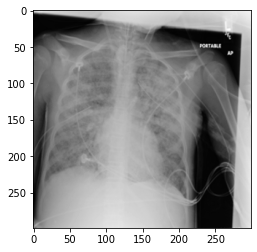

In [6]:
print("Lung_Opacity chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Lung_Opacity',lung_imgs[1]))
plt.imshow(im,cmap="gray")
plt.show()

## Image pre-processing and train-test split

In [7]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [8]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Normal/Normal-3247.png,Normal
freq,1,10192


In [9]:
df.head(2)

,id,label
0,Normal/Normal-859.png,Normal
1,Normal/Normal-158.png,Normal


In [10]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Absolute Frequency','Relative Frequency']
  return freq_a
frequency_plot(df)

,Label,Absolute Frequency,Relative Frequency
0,Normal,10192,0.481550
1,Lung_Opacity,6012,0.284054
2,Viral Pneumonia,1345,0.063548
3,COVID,3616,0.170848


## Undersampling classes


The dataset is unbalanced. As our focus is the COVID class, we will undersample classes with more examples than the COVID class and keep classes with less examples.

In [11]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)


traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [12]:
frequency_plot(traindf)

,Label,Absolute Frequency,Relative Frequency
0,Viral Pneumonia,1009,0.063567
1,Normal,7643,0.481509
2,Lung_Opacity,4509,0.284067
3,COVID,2712,0.170856


In [13]:
frequency_plot(valdf)

,Label,Absolute Frequency,Relative Frequency
0,Normal,1274,0.481481
1,Lung_Opacity,752,0.284203
2,Viral Pneumonia,168,0.063492
3,COVID,452,0.170824


In [14]:
frequency_plot(testdf)

,Label,Absolute Frequency,Relative Frequency
0,Normal,1275,0.481859
1,COVID,452,0.170824
2,Lung_Opacity,751,0.283825
3,Viral Pneumonia,168,0.063492


## Image Data Generator

In [15]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [16]:
BATCH_SIZE=50


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)


val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 15873 validated image filenames belonging to 4 classes.
Found 2646 validated image filenames belonging to 4 classes.

Creating val generator...
Found 2646 validated image filenames belonging to 4 classes.


In [17]:
train_generator.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

# Classifier Model

# 1. Simple CNN fully connected layers

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

## 1.1 Model Building

In [19]:
# CNN Based Model in Keras

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

## 1.2 Model visualization

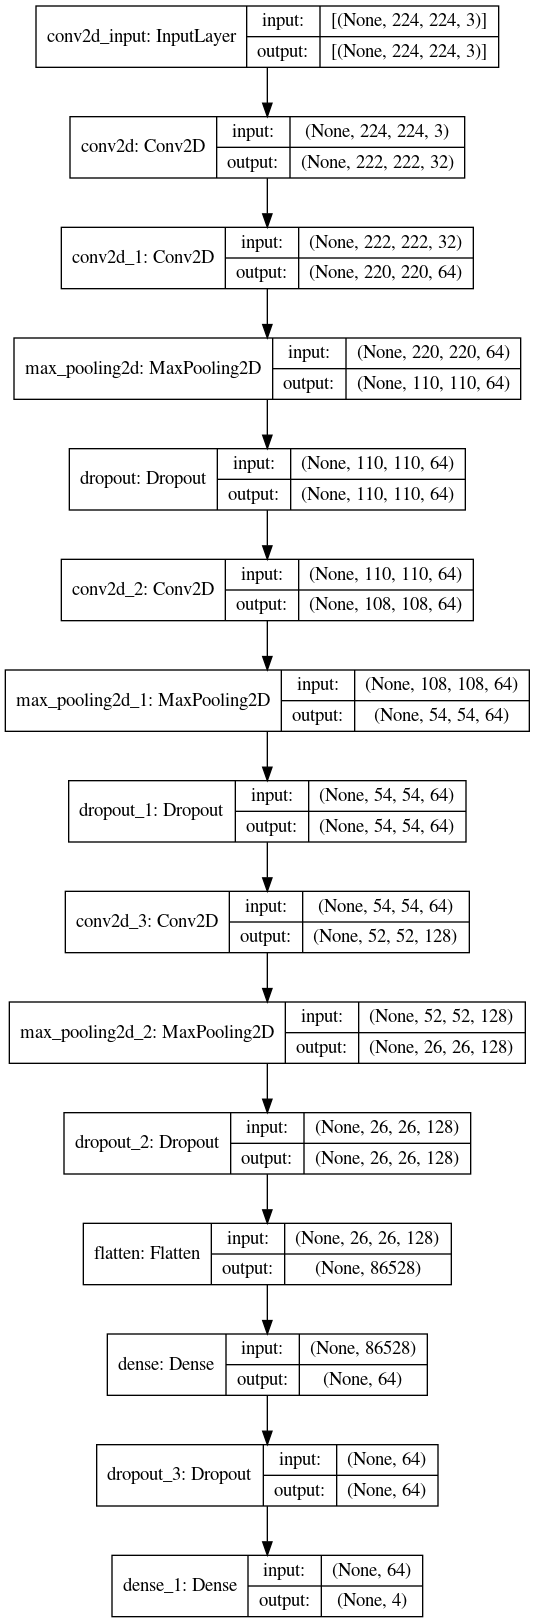

In [20]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

## 1.3 Training above Model

In [21]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [22]:
EPOCHS = 10
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 16s 252ms/step - loss: 1.2378 - recall: 0.1121 - precision: 0.5113 - acc: 0.4729 - val_loss: 1.2746 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.4600
Epoch 2/10
50/50 [==============================] - 11s 227ms/step - loss: 1.1603 - recall: 0.1919 - precision: 0.6157 - acc: 0.4905 - val_loss: 1.2321 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.5360
Epoch 3/10
50/50 [==============================] - 11s 224ms/step - loss: 1.0944 - recall: 0.2575 - precision: 0.6848 - acc: 0.5365 - val_loss: 1.1839 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.5720
Epoch 4/10
50/50 [==============================] - 11s 220ms/step - loss: 1.0333 - recall: 0.3193 - precision: 0.7157 - acc: 0.5643 - val_loss: 1.1439 - val_recall: 0.0040 - val_precision: 1.0000 - val_acc: 0.6120
Epoch 5/10
50/50 [==============================] - 12s 229ms/step - loss: 0.9844 - recall: 0.3643 - precision: 0.71

In [23]:
history1.history.keys()

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])

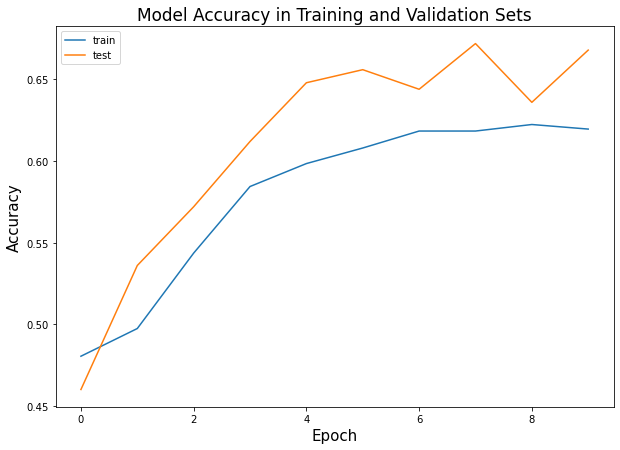

In [24]:
# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy in Training and Validation Sets', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Simple_CNN_Tr&Vl_accuracies.png',transparent=False)
plt.show()

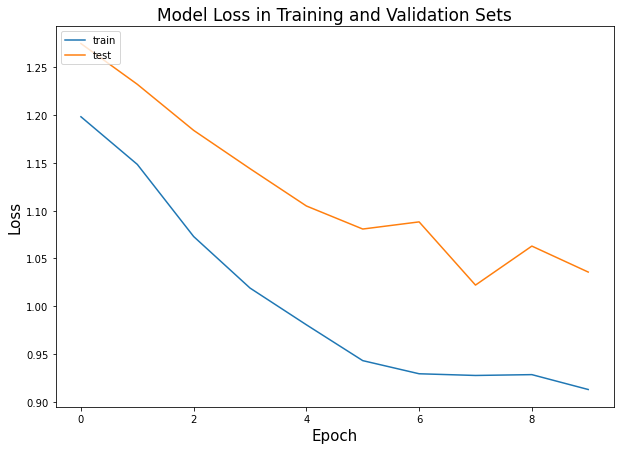

In [25]:
plt.figure(figsize=(10,7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss in Training and Validation Sets', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Simple_CNN_Tr&Vl_losses.png',transparent=False)
plt.show()

# 2. VGG Model as Base 

## 2.1 Importing VGG

In [26]:
# The ImageNet dataset contains images of fixed size of 224*224 . So, we have a tensor of (224, 224, 3) as our input. 
# This model process the input image and outputs the a vector of 1000 values.

from keras.applications.vgg16 import VGG16
base_convnet = VGG16(include_top=False, input_shape=input_shape,
                     weights='imagenet')


#Freeze base convolutional layers
base_convnet.trainable = False
base_convnet.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 2.2 Connecting VGG base to Neural Network

In [27]:
model = models.Sequential()
model.add(base_convnet)

model.add(layers.Flatten())  # Flatten layer is used to make the multidimensional input one-dimensional

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))   # Dropout is a technique used to improve over-fit on neural networks
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                

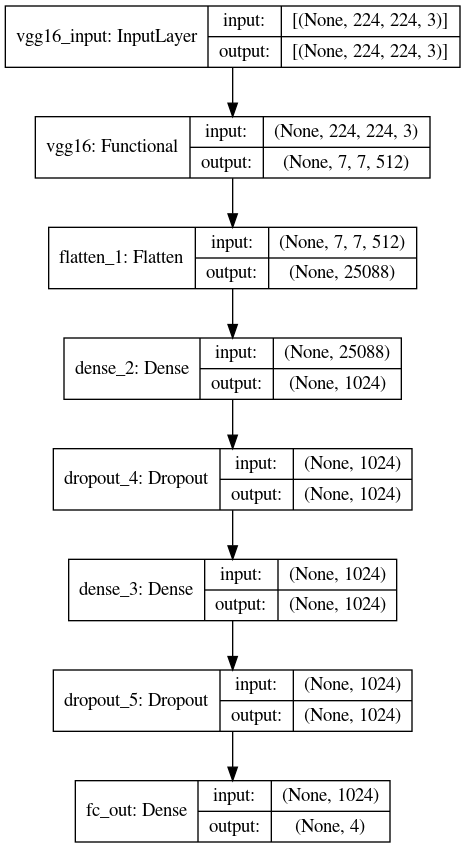

In [28]:
plot_model(model, to_file='VGG and Model.png', show_shapes=True)
Image(filename='VGG and Model.png')

## 2.3 Training above Model

In [29]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [30]:
EPOCHS = 10
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 15s 250ms/step - loss: 1.2646 - recall_1: 0.2709 - precision_1: 0.5546 - acc: 0.4634 - val_loss: 0.8441 - val_recall_1: 0.5440 - val_precision_1: 0.7953 - val_acc: 0.6320
Epoch 2/10
50/50 [==============================] - 12s 248ms/step - loss: 0.8837 - recall_1: 0.5205 - precision_1: 0.7543 - acc: 0.6390 - val_loss: 0.6935 - val_recall_1: 0.6480 - val_precision_1: 0.8060 - val_acc: 0.7280
Epoch 3/10
50/50 [==============================] - 12s 236ms/step - loss: 0.7122 - recall_1: 0.6078 - precision_1: 0.7893 - acc: 0.7216 - val_loss: 0.6490 - val_recall_1: 0.6600 - val_precision_1: 0.8049 - val_acc: 0.7440
Epoch 4/10
50/50 [==============================] - 13s 250ms/step - loss: 0.6590 - recall_1: 0.6642 - precision_1: 0.8230 - acc: 0.7637 - val_loss: 0.5435 - val_recall_1: 0.7320 - val_precision_1: 0.8472 - val_acc: 0.8040
Epoch 5/10
50/50 [==============================] - 12s 234ms/step - loss: 0.5931 - recall_1: 0.7046 - preci

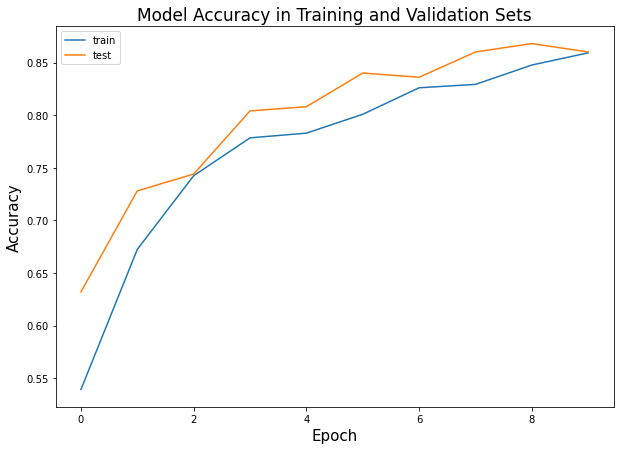

In [31]:
# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy in Training and Validation Sets', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('VGG_CNN_Tr&Vl_accuracies.png',transparent=False)
plt.show()

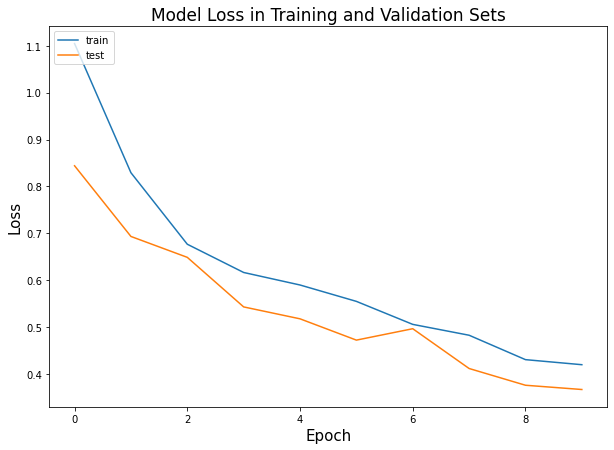

In [32]:
plt.figure(figsize=(10,7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss in Training and Validation Sets', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('VGG_CNN_Tr&Vl_losses.png',transparent=False)
plt.show()

In [33]:
model.predict(test_generator)

array([[4.0295864e-03, 1.3001673e-02, 9.8243999e-01, 5.2876509e-04],
       [7.9074305e-01, 1.5407348e-01, 5.0336055e-02, 4.8474348e-03],
       [7.4215704e-03, 2.2947362e-01, 7.6159877e-01, 1.5059814e-03],
       ...,
       [2.0273755e-01, 5.7703745e-01, 2.1588367e-01, 4.3413043e-03],
       [2.7863125e-03, 9.8313302e-01, 1.3627077e-02, 4.5357880e-04],
       [7.2529875e-03, 4.6449566e-01, 5.2568942e-01, 2.5619026e-03]],
      dtype=float32)

In [34]:
vgg16_model = model

In [35]:
vgg16_model.save('Chest_Xray_withVGG_v2.h5')

## 2.4 Evaluating above Model

In [36]:
vgg16_model.evaluate(test_generator)

89/89 [==============================] - 11s 118ms/step - loss: 0.3811 - recall_1: 0.8462 - precision_1: 0.8888 - acc: 0.8696


[0.3810626268386841,
 0.8461829423904419,
 0.8888447880744934,
 0.8696145415306091]

In [37]:
from sklearn.metrics import classification_report

test_pred_raw = vgg16_model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       452
           1       0.78      0.90      0.83       751
           2       0.90      0.88      0.89      1275
           3       0.96      0.89      0.92       168

    accuracy                           0.87      2646
   macro avg       0.90      0.86      0.87      2646
weighted avg       0.88      0.87      0.87      2646

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


### confusion matrix code

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm / np.expand_dims(cm.sum(axis=1),axis=1)
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      pass

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Confusion Matrix

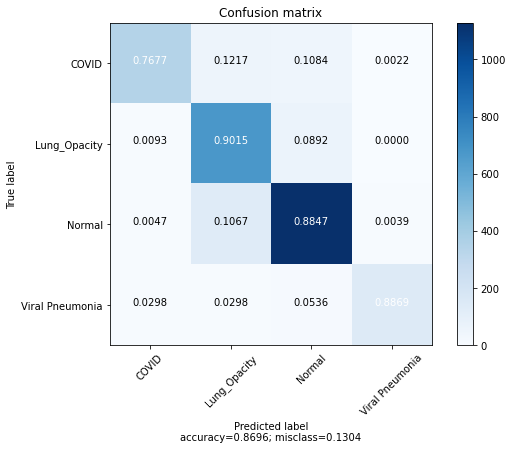

AttributeError: 'NoneType' object has no attribute 'savefig'

In [39]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
x = plot_confusion_matrix(cm,class_names)
x.savefig('VGG_CM.png')

In [ ]:
vgg16_model.save('Chest_Xray_withVGG.h5')

# 3. EfficientNet

In [ ]:
pip install efficientnet

In [40]:
# The ImageNet dataset contains images of fixed size of 224*224 . So, we have a tensor of (224, 224, 3) as our input. 
# This model process the input image and outputs the a vector of 1000 values.

import efficientnet.keras as efn
base_convnet = efn.EfficientNetB0(include_top=False, input_shape=input_shape,
                     weights='imagenet')


#Freeze base convolutional layers
base_convnet.trainable = False
base_convnet.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [41]:
model = models.Sequential()
model.add(base_convnet)

model.add(layers.Flatten())  # Flatten layer is used to make the multidimensional input one-dimensional

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))   # Dropout is a technique used to improve over-fit on neural networks
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                

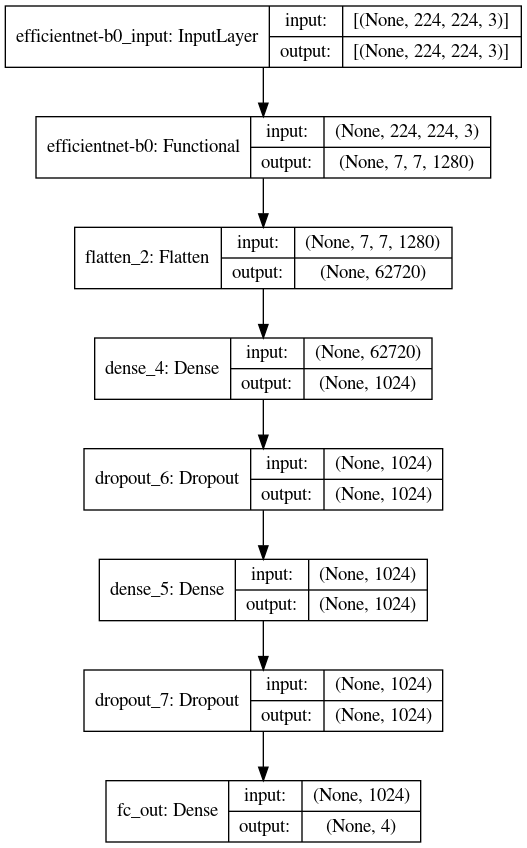

In [42]:
plot_model(model, to_file='EN and Model.png', show_shapes=True)
Image(filename='EN and Model.png')

In [43]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [44]:
EPOCHS = 10
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
50/50 [==============================] - 21s 306ms/step - loss: 1.0222 - recall_2: 0.4689 - precision_2: 0.6489 - acc: 0.5689 - val_loss: 0.5114 - val_recall_2: 0.7880 - val_precision_2: 0.8455 - val_acc: 0.8040
Epoch 2/10
50/50 [==============================] - 14s 288ms/step - loss: 0.6130 - recall_2: 0.7307 - precision_2: 0.8014 - acc: 0.7743 - val_loss: 0.4353 - val_recall_2: 0.8240 - val_precision_2: 0.8766 - val_acc: 0.8520
Epoch 3/10
50/50 [==============================] - 14s 273ms/step - loss: 0.5075 - recall_2: 0.7792 - precision_2: 0.8371 - acc: 0.8111 - val_loss: 0.3891 - val_recall_2: 0.8440 - val_precision_2: 0.8719 - val_acc: 0.8600
Epoch 4/10
50/50 [==============================] - 14s 275ms/step - loss: 0.4138 - recall_2: 0.8333 - precision_2: 0.8671 - acc: 0.8483 - val_loss: 0.4489 - val_recall_2: 0.8400 - val_precision_2: 0.8642 - val_acc: 0.8560
Epoch 5/10
50/50 [==============================] - 14s 274ms/step - loss: 0.4196 - recall_2: 0.8107 - preci

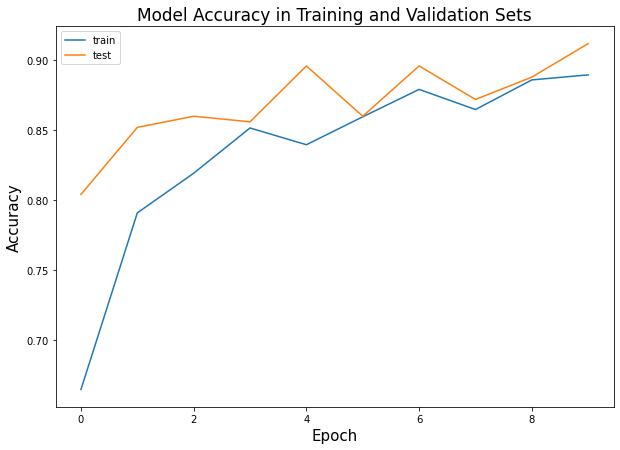

In [45]:
# summarize history for accuracy
plt.figure(figsize=(10,7))
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy in Training and Validation Sets', fontsize=17)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('EN_CNN_Tr&Vl_accuracies.png',transparent=False)
plt.show()

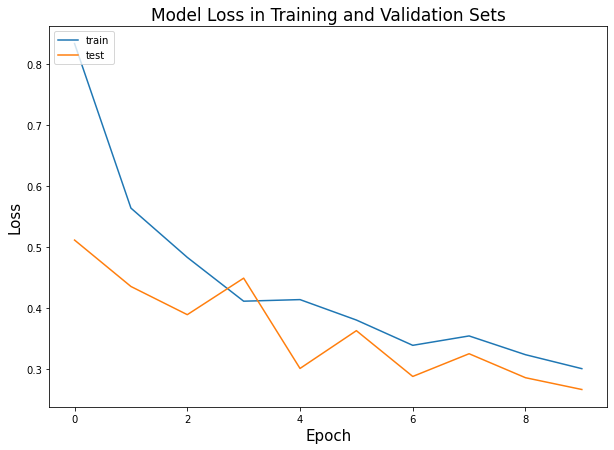

In [46]:
plt.figure(figsize=(10,7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss in Training and Validation Sets', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('EN_CNN_Tr&Vl_losses.png',transparent=False)
plt.show()

In [47]:
model.evaluate(test_generator)

89/89 [==============================] - 14s 151ms/step - loss: 0.2604 - recall_2: 0.8957 - precision_2: 0.9115 - acc: 0.9036


[0.2604207992553711,
 0.8956916332244873,
 0.9115384817123413,
 0.9036281108856201]

In [ ]:
model.save('Chest_Xray_Ef.h5')

In [48]:
from sklearn.metrics import classification_report

test_pred_raw = model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       452
           1       0.87      0.85      0.86       751
           2       0.91      0.91      0.91      1275
           3       0.96      0.96      0.96       168

    accuracy                           0.90      2646
   macro avg       0.91      0.92      0.91      2646
weighted avg       0.90      0.90      0.90      2646

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


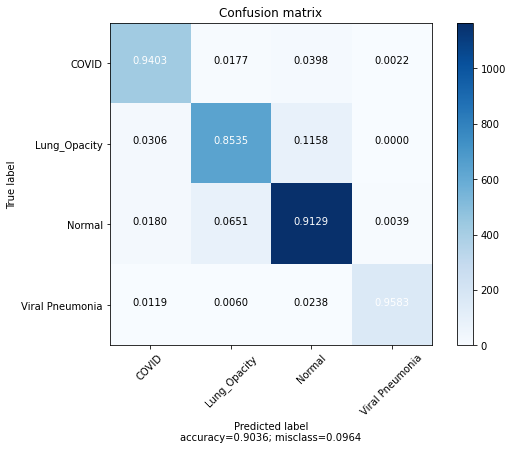

In [49]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm,class_names)
